## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Подключим необходимые библиотеки для проекта

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy import stats as st
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import  mean_squared_error

In [2]:
class DataScience:

    def rmse(self,predictions, targets): 
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    
    def plot_feature_importance(self,importance,names,model_type):

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
        
        
ds = DataScience()

Откроем файл с данными. 

In [3]:
#df = pd.read_csv('C:/Users/Axmet/Downloads/taxi.csv')
df = pd.read_csv('/datasets/taxi.csv')

Выведем первые 5 строк

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.sort_index(inplace=True)
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Проверим наличие пустых значений

In [7]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Проверим упорядочен ли наш index

In [8]:
df = df.set_index('datetime')
df.index.is_monotonic

True

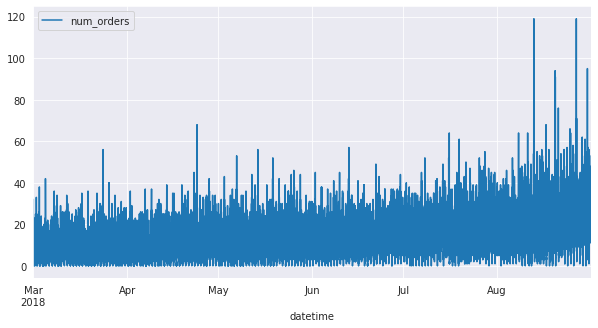

In [9]:
df.plot()


# 2. Анализ

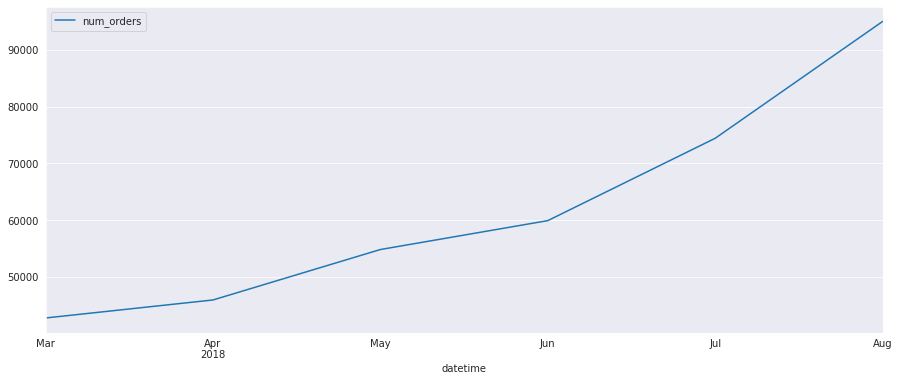

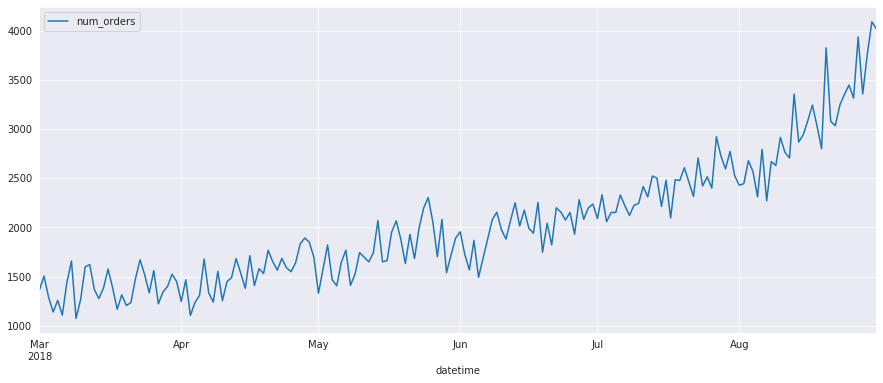

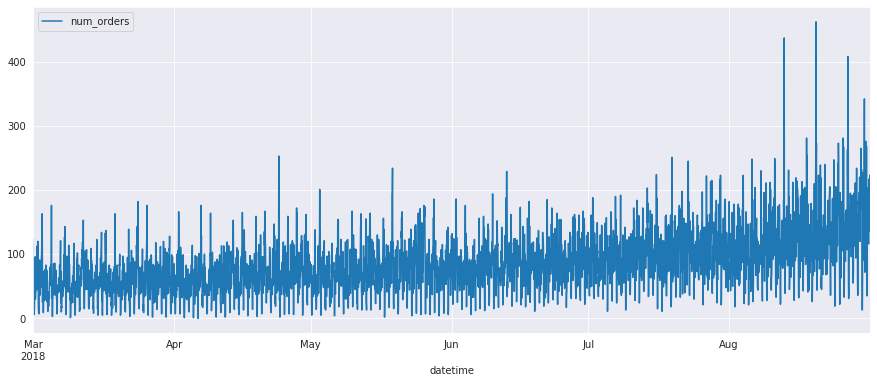

In [10]:
df.resample('1M').sum().plot(figsize=(15, 6))
df.resample('1D').sum().plot(figsize=(15, 6))
df = df.resample('1H').sum()
df.plot(figsize=(15, 6))

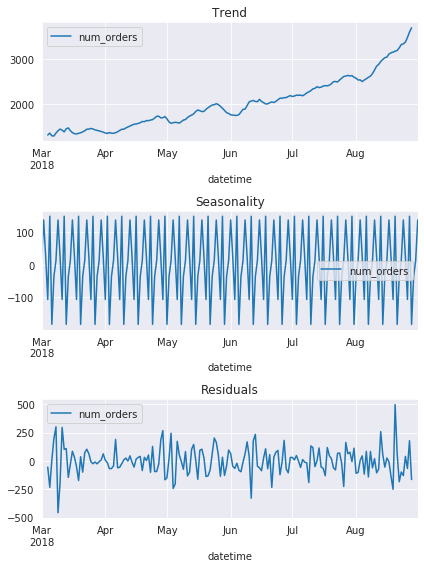

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1D').sum()

decomposed = seasonal_decompose(data)

#decomposed.seasonal.plot()


plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

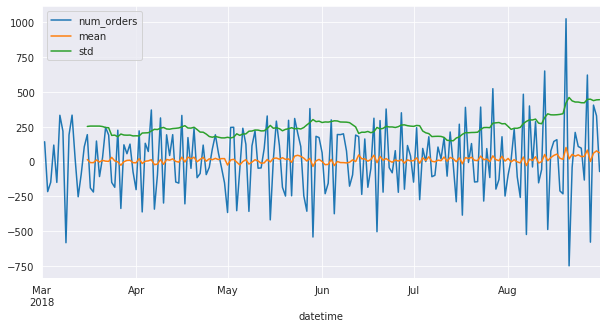

In [12]:
data = data - data.shift()  
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

Ряд нестационарный, т.к. со временем меняется стреднее значение

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(df, 5, 4)
df.head(30)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,86.50
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,66.25
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,46.50
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,31.75
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,19.00


In [15]:
train, valid_plus_test = train_test_split(df, shuffle=False, test_size=0.4, random_state=123)
valid, test = train_test_split(valid_plus_test, shuffle=False, test_size=0.25, random_state=123)
train = train.dropna()
valid = valid.dropna()
test = test.dropna()
print('Обучающая выборка:')
print(train.shape)
print(train.index.min(), train.index.max())
print('-----')
print('Валидационная выборка:')
print(valid.shape)
print(valid.index.min(), valid.index.max())
print('-----')
print('Тестовая выборка:')
print(test.shape)
print(test.index.min(), test.index.max())

Обучающая выборка:
(2644, 9)
2018-03-01 05:00:00 2018-06-19 08:00:00
-----
Валидационная выборка:
(1325, 9)
2018-06-19 09:00:00 2018-08-13 13:00:00
-----
Тестовая выборка:
(442, 9)
2018-08-13 14:00:00 2018-08-31 23:00:00


In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


# 3. Обучение

In [17]:
#выполним ресемплирование по одному часу
df = df.resample('1H').sum()

#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [18]:
df.describe()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,lag_6,lag_7,lag_8,lag_9
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4407.000000,4410.000000,4409.000000,4408.000000,4407.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.320198,84.291837,84.261737,84.236162,84.228954
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,30.263125,44.898387,44.858959,44.831888,44.834421
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,25.888889,0.000000,0.000000,0.000000,0.000000
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,62.555556,54.000000,54.000000,54.000000,54.000000
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,79.888889,78.000000,78.000000,78.000000,78.000000
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,101.111111,107.000000,107.000000,107.000000,107.000000
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,223.111111,462.000000,462.000000,462.000000,462.000000


Разделим нашу таблилцу на обучающую и тестовую выборки

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Определим признаки и целевой признак у обучающей и тестовой выборок

In [20]:
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

Проверим правильно ли расположены временные даннные, нельзя допустить в обучающую выборку данные из будущего

In [21]:
display(train.head(3))
display(test.head(3))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,lag_6,lag_7,lag_8,lag_9
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,9,34.0,15.0,12.0,6.0,43.0,50.666667,66.0,71.0,85.0,124.0
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,6.0,44.555556,43.0,66.0,71.0,85.0
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,12.0,42.222222,6.0,43.0,66.0,71.0


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,lag_6,lag_7,lag_8,lag_9
datetime,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,103.000000,91.0,39.0,66.0,83.0
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,105.111111,137.0,91.0,39.0,66.0
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,117.222222,156.0,137.0,91.0,39.0


Размеры обучающей и тестовой выборки

In [22]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3965 объектов, 12 признаков
Размер тестовой выборки: 442 объектов, 12 признаков


# LinearRegression

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=-1)
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE:', ds.rmse(lr_predictions,y_test))

RMSE: 54.08758434757491


Попробуем подобрать параметры с помощью цикла

In [24]:
estimators = [50,100,200,300]
forleaves = [2,5,7,12]


for estim, leaves in zip(estimators, forleaves):
    lgb_model = lgb.LGBMRegressor(n_estimators=estim, num_leaves=leaves)
    lgb_model.fit(X,y)
    predictions = lgb_model.predict(X)
    print('RMSE with n_estimators : {} and num_leaves: {} is {}'.format(estim, leaves, ds.rmse(predictions, y)))

RMSE with n_estimators : 50 and num_leaves: 2 is 29.447685769072727
RMSE with n_estimators : 100 and num_leaves: 5 is 22.159400472645576
RMSE with n_estimators : 200 and num_leaves: 7 is 19.212092776098753
RMSE with n_estimators : 300 and num_leaves: 12 is 14.89407898647034


LightGBM показал лучший результат на обучающей выборке с ним и будем работать дальше

# 4. Тестирование

In [25]:
model = lgb.LGBMRegressor(
                          n_estimators=300,
                          num_leaves=12,
                          objective='regression'
)

model.fit(X,y)
predictions = model.predict(X_test)
print('RMSE на тестовой выборке:', ds.rmse(predictions,y_test))

RMSE на тестовой выборке: 43.92340606427539


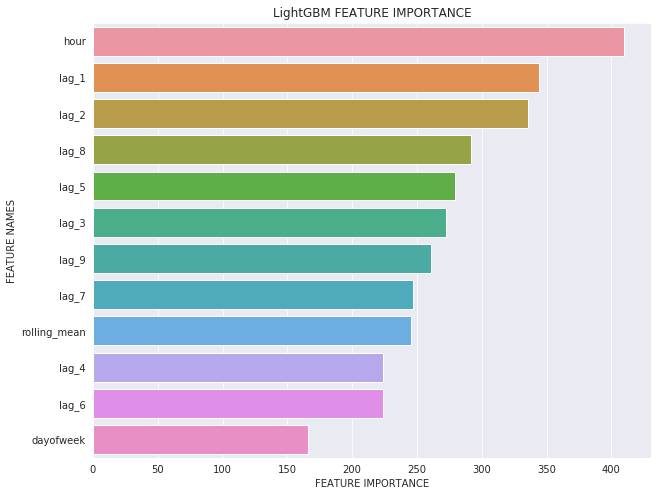

In [26]:
ds.plot_feature_importance(model.feature_importances_,X_test.columns,'LightGBM ')

Выведем на графике реальное количество заказов в день и предсказанное нашей моделью. 

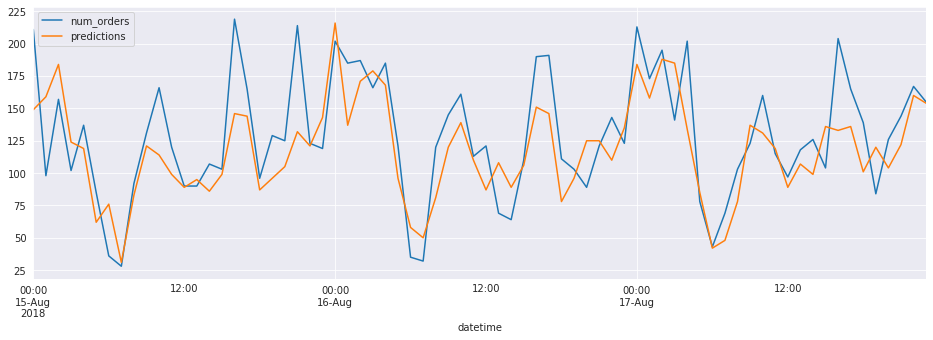

In [27]:
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

# Выводы

В результате выполнения проекта построена модель машинного обученния, которая прогнозирует количество заказов на будущие промежутки времени с минимальным значением метрики RMSE на тестовой выборке.

Также в процессе выполнения работы была выполнена предподготовка данных, анализ временных рядов, создание тренировочной, валидационной и тестовой выборки, обучение разных видов моделей машинного обучения, вывод значения целевой метрики и важности признаков для каждой модели, а также проверка результата на тестовой выборке. В принципе все рассмотренные модели удовлетворяют условию технического задания и имеют RMSE < 48. Однако как наиболее быстро работающую модель, я бы рекомендовал использовать DecisionTreeRegressor, как модель с самым быстрым временем работы и отличным значением целевой метрики на тестовой выборке (RMSE=3.3)